<a href="https://colab.research.google.com/github/Mejayyy/AnomalyDet/blob/main/AD_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyod
!pip install scikit-learn



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=5763735f4b9b05ec7b65e8b583874c4433330dc90e31664a169b862e2dfc7a37
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [14]:
from pyod.utils.data import generate_data
import numpy as np
import matplotlib.pyplot as plt

cont=0.1

x_train,x_test,y_train,y_test=generate_data(n_train = 4000, n_test=1000, n_features = 2, contamination = cont)
print(y_train)


[0. 0. 0. ... 1. 1. 1.]


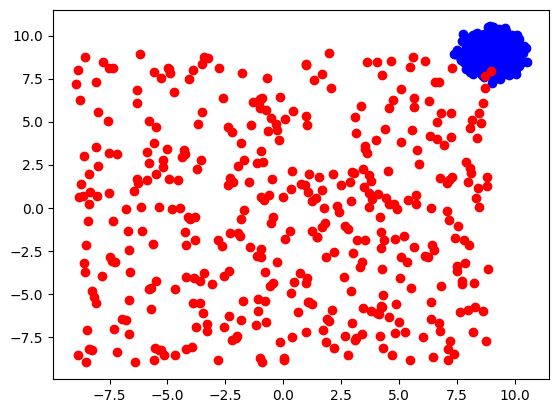

In [15]:
normal_samples = x_train[y_train == 0]
outlier_samples = x_train[y_train == 1]


plt.scatter(normal_samples[:, 0], normal_samples[:, 1], c='blue', label='Normal')
plt.scatter(outlier_samples[:, 0], outlier_samples[:, 1], c='red', label='Outliers')


In [16]:
from pyod.models.knn import KNN
from sklearn.metrics import confusion_matrix,roc_curve

knn=KNN(contamination= cont)
knn.fit(x_train)


y_train_pred=knn.labels_
y_train_scores = knn.decision_scores_

y_test_pred=knn.predict(x_test)
y_test_scores = knn.decision_function(x_test)

cm = confusion_matrix(y_test, y_test_pred)

TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

balanced_accuracy = (TPR + TNR) / 2

print(balanced_accuracy)

0.9994444444444445


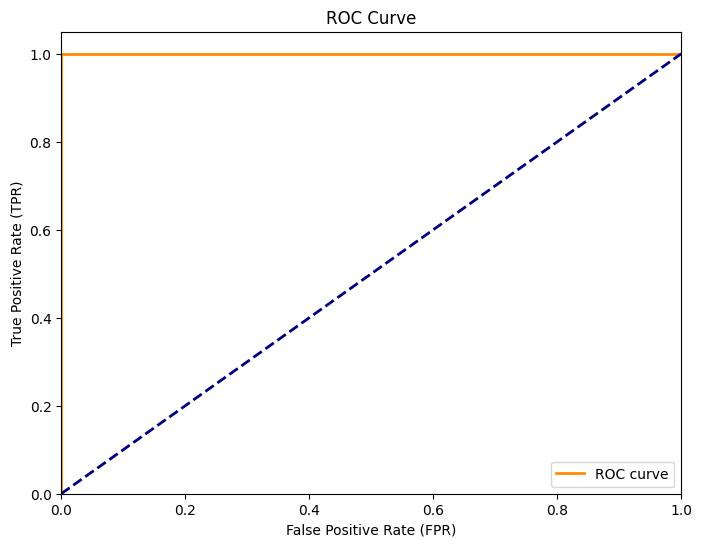

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')


plt.show()


In [41]:
np.random.seed(421)

cont=0.1

x,y=generate_data(n_train = 1000,train_only=True,n_features = 1, contamination = cont,)
#print(x,y)
mean=np.mean(x)
std=np.std(x)
print("\nMean ul este ",np.mean(x))
print("\nSTD ul este : ",np.std(x))


def z_score(t):
  return np.abs(t-mean)/std


z=z_score(x)
#print(z)

threshold=np.quantile(z,0.9)
print("\nValoarea de threshold este: ",threshold)
anomalies = z > threshold
y_pred_zscore=np.zeros(1000)
for i in range(0,1000):
  if z[i]>threshold:
    y_pred_zscore[i]=1


cm = confusion_matrix(y, y_pred_zscore)

TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

balanced_accuracy = (TPR + TNR) / 2

print("\nAcuratetea acestei metode este: ",balanced_accuracy)




Mean ul este  6.2675272546340555

STD ul este :  2.564088907611719

Valoarea de threshold este:  0.5837198009069722

Acuratetea acestei metode este:  0.8944444444444445


In [42]:
#Cholesky si rezolvarea sistemelor liniare

def pozitiv(A):
    n = np.shape(A)[0]
    assert n == np.shape(A)[1]
    for k in range(n):
        assert np.linalg.det(A[:k, :k]) > 0

def Cholesky(M):
    A = np.copy(M)
    n = np.shape(A)[0]
    assert n == np.shape(A)[1]
    assert np.all(A == np.transpose(A))
    pozitiv(A)
    L = np.zeros((n, n))
    for i in range(n):
        L[i, i] = A[i, i] ** (1 / 2)
        L[i+1:n,i] = A[i+1:n,i] / L[i, i]
        A[i + 1:, i + 1:] = A[i + 1:, i + 1:] - np.outer(L[i + 1:, i], L[i+1:,i].T)
    return L

def subDesc(U,b):
    n=np.shape(U)[0]
    assert n==np.shape(U)[1] , 'Nu e patratica'
    for j in range(n):
        for i in range(j+1,n):
            assert U[i,j]==0, 'U nu e sup triunghiulara'
    assert n==np.shape(b)[0], 'b nu are nr. bun de intrari'
    for i in range(n):
        assert U[i,i]!=0, 'U nu e inversabila'

    x=np.ones((n,1))

    x[n-1]=b[n-1]/U[n-1,n-1]

    for k in range(n-2,-1,-1):
        s=0
        for p in range(n-1,k,-1):
            s=s+ U[k,p]*x[p]
        x[k]=(b[k]-s)/U[k,k]
    return x

def subAsc(L,b):
    n=np.shape(L)[0]
    assert n==np.shape(L)[1] , 'Nu e patratica'
    for i in range(n):
        for j in range(i+1,n):
            assert L[i,j]==0, 'L nu inf triunghiulara'
    assert n==np.shape(b)[0], 'b nu are nr. bun de intrari'
    for i in range(n):
        assert L[i,i]!=0, 'L nu e inversabila'

    x=np.ones((n,1))

    x[0]=b[0]/L[0,0]

    for k in range(1,n):
        s=0
        for p in range(k):
            s=s+ L[k,p]*x[p]
        x[k]=(b[k]-s)/L[k,k]

    return x


In [43]:
mean=np.array([0,3,2])
cov=np.array([
    [1,0,0],
    [0,5,0],
    [0,0,0.2]
])


#Generare date +anomalii
data = np.random.multivariate_normal(mean, cov, 900)
anomaly=np.random.uniform(-10,10,size=(100,3))

y_ground=np.zeros(1000)
for i in range(0,1000):
  y_ground[i]=0
  if i>=900:
    y_ground[i]=1

x = np.vstack((data, anomaly))
#print(x)

#Calcul Z-score

def z_score_m(t):

  w=t-mean
  L=Cholesky(cov)

  #v=E_{-1} * w
  #rezolv E*v = w
  #rezolv L * L.t * v = w
  #print(w.size)
  v_0=subAsc(L,w)
  v=subDesc(L.T,v_0)
  return np.dot(w.T,v)


z=np.apply_along_axis(z_score_m, 1, x)


threshold=np.quantile(z,0.9)
print("\nValoarea de threshold este: ",threshold)
anomalies = z > threshold
y_pred_zscore=np.zeros(1000)




for i in range(0,1000):
  if z[i]>threshold:
    y_pred_zscore[i]=1


cm = confusion_matrix(y_ground, y_pred_zscore)

TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

balanced_accuracy = (TPR + TNR) / 2

print("\nAcuratetea acestei metode este: ",balanced_accuracy)




Valoarea de threshold este:  11.045814641085586

Acuratetea acestei metode este:  0.9888888888888889
